## Introduction

As a follow up from the previous prediction for Ames datasets, this time around we are going to create a dataset, we will be pedicting prices with ames dataset and will be performing EDA on the same dataset but this time around using boosting techniques and data analysis to improve prediction and using pipelines to ensure that our code is neat and easily used.

In [132]:
conda create -n tensorflow python=3.8 -y

Solving environment: done

## Package Plan ##

  environment location: /Users/lindaoranya/opt/anaconda3/envs/tensorflow

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  ca-certificates    pkgs/main/osx-64::ca-certificates-2021.7.5-hecd8cb5_1
  certifi            pkgs/main/osx-64::certifi-2021.5.30-py38hecd8cb5_0
  libcxx             pkgs/main/osx-64::libcxx-12.0.0-h2f01273_0
  libffi             pkgs/main/osx-64::libffi-3.3-hb1e8313_2
  ncurses            pkgs/main/osx-64::ncurses-6.2-h0a44026_1
  openssl            pkgs/main/osx-64::openssl-1.1.1l-h9ed2024_0
  pip                pkgs/main/osx-64::pip-21.0.1-py38hecd8cb5_0
  python             pkgs/main/osx-64::python-3.8.11-h88f2d9e_1
  readline           pkgs/main/osx-64::readline-8.1-h9ed2024_0
  setuptools         pkgs/main/osx-64::setuptools-52.0.0-py38hecd8cb5_0
  sqlite             pkgs/main/osx-64::sqlite-3.36.0-hce871da_0
  tk                 pkgs/main/osx-64::tk-8.6.10-hb0a8c7a_0
 

In [133]:
conda activate tensorflow


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


In [134]:
!pip install --ignore-installed --upgrade tensorflow

  Using cached tensorflow-2.6.0-cp38-cp38-macosx_10_11_x86_64.whl (199.0 MB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached numpy-1.19.5-cp38-cp38-macosx_10_9_x86_64.whl (15.6 MB)
Processing /Users/lindaoranya/Library/Caches/pip/wheels/f1/60/77/22b9b5887bd47801796a856f47650d9789c74dc3161a26d608/clang-5.0-py3-none-any.whl
Processing /Users/lindaoranya/Library/Caches/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73/wrapt-1.12.1-cp38-cp38-macosx_10_9_x86_64.whl
  Using cached protobuf-3.17.3-cp38-cp38-macos

In [135]:
#import libraries
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from scipy.stats import skew
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import  GradientBoostingRegressor
from xgboost import XGBRegressor


print("Modules imported \n")

get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

Modules imported 



In [136]:
# Load raw data
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 

## EDA

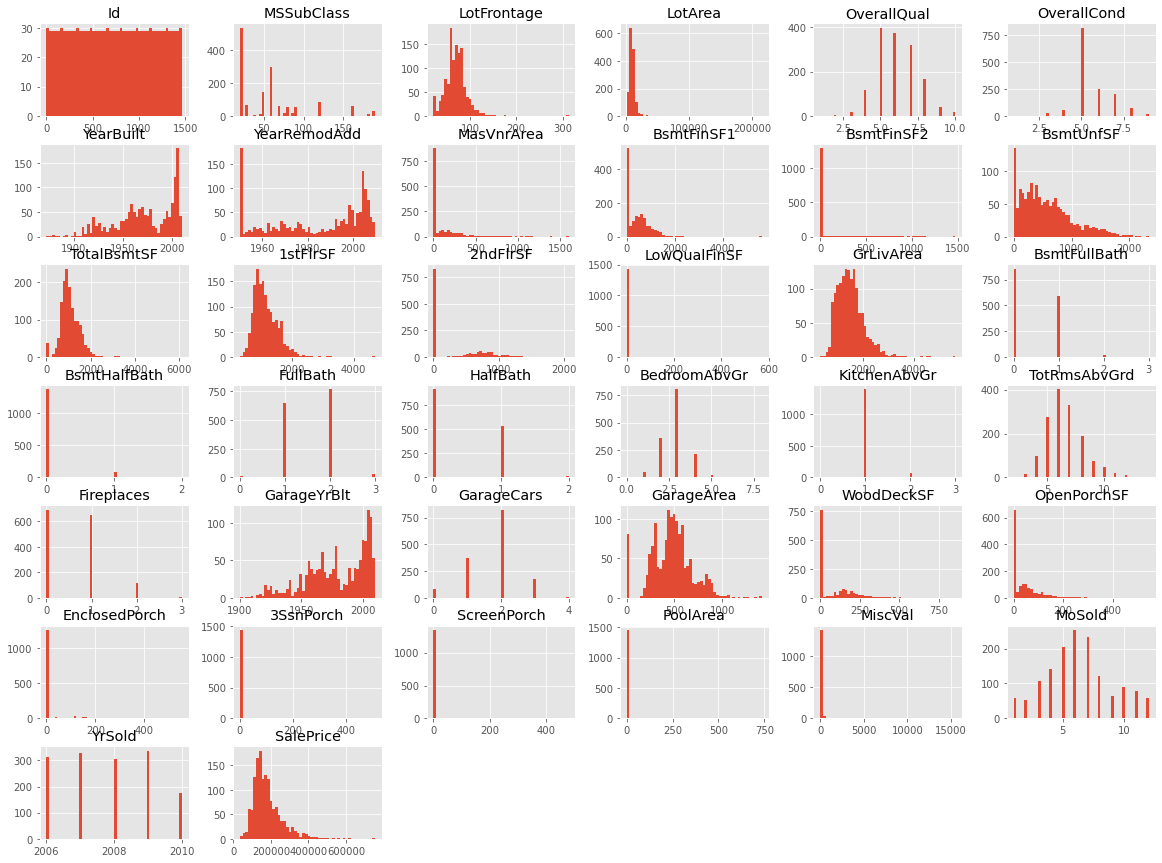

In [137]:
# Histograms
train.hist(bins=50, figsize=(20,15))
plt.show()

- Lotfrontage, LotArea,BsmtFullBath, 1stFloorSF, GrLiveArea and SalePrice are positively skewed.
- TotalBsmtSF,GarageYrBlt are negatively skewed.

In [138]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


- The earliest year sold of a house is 2006 and the latest year sold is 2010.
- The cheapest house sold at 34900 and the most expensive is 755000.
- The latest hosue was also built in 2010

In [139]:
# Pearson Correlation Coefficient
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

##### thoughts

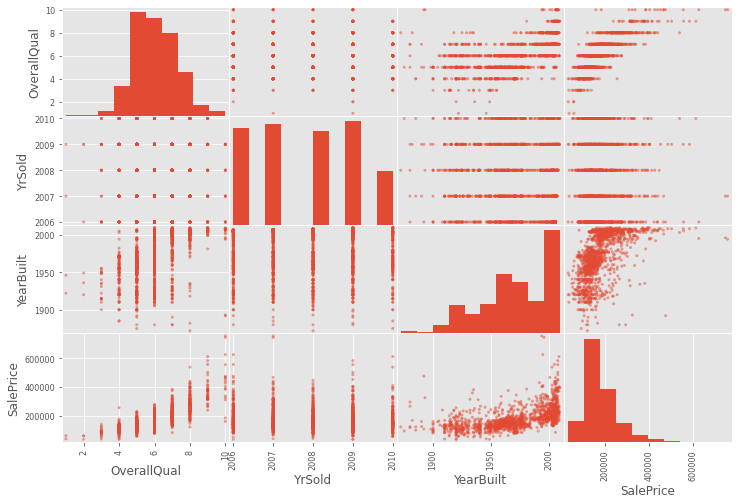

In [140]:
# Scatter_matrix
attributes = ["OverallQual", "YrSold", "YearBuilt","SalePrice"]
scatter_matrix(train[attributes], figsize=(12, 8));

- We can see that there is a relationship between the SalePrice and the Overall Quality of the house.
- Year built and the Sale Price are also correlated.

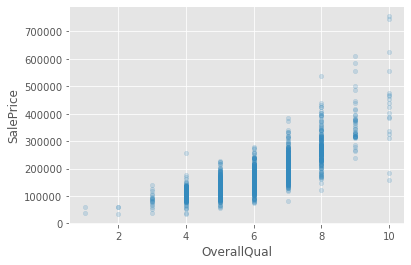

In [141]:
# Zoom in on one plot
train.plot(kind="scatter", x="OverallQual", y="SalePrice",alpha=0.2);

Some transformation should be done on train + test
If not done there will be a difference between the columns in train and test after get_dummies as there are different columns in train vs test

Scaling will be separately so as not to influence the mean and std of train with those of test, this leads to snooping on the test and overfitting

In [142]:
trainWprice = pd.DataFrame(train)
trainNoPrice = trainWprice.drop("SalePrice", axis=1)

full=pd.concat([trainNoPrice,test], ignore_index=True)
full.drop(['Id'],axis=1, inplace=True)

print("train ", train.shape)
print("test ", test.shape)
print("full without Id and no SalePrice ", full.shape)

train  (1460, 81)
test  (1459, 80)
full without Id and no SalePrice  (2919, 79)


In [143]:
# Missing Data
ColsMissingValues = full.isnull().sum()
print("There are ", len(ColsMissingValues[ColsMissingValues>0]), " features with missing values")

all_data_na = (full.isnull().sum() / len(full)) * 100
all_data_na = all_data_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data.head(len(ColsMissingValues[ColsMissingValues>0])))


There are  34  features with missing values
              Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
FireplaceQu       48.646797
LotFrontage       16.649538
GarageCond         5.447071
GarageQual         5.447071
GarageYrBlt        5.447071
GarageFinish       5.447071
GarageType         5.378554
BsmtCond           2.809181
BsmtExposure       2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrType         0.822199
MasVnrArea         0.787941
MSZoning           0.137033
BsmtHalfBath       0.068517
Utilities          0.068517
Functional         0.068517
BsmtFullBath       0.068517
BsmtFinSF2         0.034258
BsmtFinSF1         0.034258
Exterior2nd        0.034258
BsmtUnfSF          0.034258
TotalBsmtSF        0.034258
Exterior1st        0.034258
SaleType           0.034258
Electrical         0.034258
KitchenQual        0.034258
GarageArea         0.034258
Gara

In [144]:
class FeatureEngineering():
    def __init__(self, fill_missvals = True):
        self.fill_missvals = fill_missvals
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        """
        Fills null values
        """
        if self.fill_missvals:
            X["PoolQC"] = X["PoolQC"].fillna("None")
            X["MiscFeature"] = X["MiscFeature"].fillna("None")
            X["Alley"] = X["Alley"].fillna("None")
            X["Fence"] = X["Fence"].fillna("None")
            X["FireplaceQu"] = X["FireplaceQu"].fillna("None")
            X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
            X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])            
            X["Functional"] = X["Functional"].fillna("Typ")
            X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode()[0])
            X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode()[0])
            X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
            X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])
            X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])
            X['MSSubClass'] = X['MSSubClass'].fillna("None")

            for col in ('GarageType', 'GarageFinish', 'GarageQual', 
                        'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                        'BsmtFinType1', 'BsmtFinType2','MasVnrType'):
                X[col] = X[col].fillna('None')
                
            for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
                X[col] = X[col].fillna(0)
                
            for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
                X[col] = X[col].fillna(0)
                
            X['MSSubClass'] = X['MSSubClass'].apply(str) 
            X['OverallCond'] = X['OverallCond'].astype(str)
            X['YrSold'] = X['YrSold'].astype(str)
            X['MoSold'] = X['MoSold'].astype(str)
            
            X = X.drop(['Utilities'], axis=1)
            
        return X

In [145]:
class AddFeature():
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        """
        Transforms dataframe by adding new features
        """
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

        return X

In [146]:
class SkewDummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.75):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        """
        Skews numerical columns
        """
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        
        return X

In [147]:
class LabelEncode(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        """
        Performs Label Encoder
        """     
        lab = LabelEncoder()
        
        cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

        for c in cols:
            X[c] = lab.fit_transform(X[c])
        
        return X

In [148]:
class Grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        """
        Performs grid search
        """
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [150]:
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, remove_cols = True):
        self.remove_cols = remove_cols
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        """
        Deletes unwanted columns
        """
        if self.remove_cols:
            del X['PoolQC']
            del X['BsmtFinType1']
            del X['LowQualFinSF']
            del X['MoSold']
            del X['Electrical']
            del X['BldgType']
            del X['SaleType']
            del X['BsmtFinSF2']
            del X['Exterior2nd']
            del X['ExterCond']
            del X['2ndFlrSF']
            del X['3SsnPorch']
            del X['Exterior1st']
            del X['MasVnrType']
            del X['GarageFinish']
            del X['Alley']
            del X['PoolArea']
            del X['RoofStyle']
            del X['MiscFeature']
            del X['Fence']
            del X['BsmtHalfBath']
            del X['Street']
            del X['LotConfig']
            del X['TotalBsmtSF']
            del X['GarageYrBlt']
          
        return X

### Pipeline

In [152]:
pipe = Pipeline([
    ('feat_eng', FeatureEngineering()),
    ('add_feature', AddFeature(additional=2)),
    ('lab_enc', LabelEncode()), 
    ('drop_cols', DropCols()), 
    ('skew_dummies', SkewDummies(skew=1)), 
    
    ])
# skew_dummies is taking care of the labelencoder AND onehotencoder with get_dummies()

train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 

trainWprice = pd.DataFrame(train)
trainNoPrice = trainWprice.drop("SalePrice", axis=1)

full=pd.concat([trainNoPrice,test], ignore_index=True)
full.drop(['Id'],axis=1, inplace=True)
print("full data without Id and SalePrice ", full.shape)

FullDataPipe = pipe.fit_transform(full)
print("FullDataPipe ", FullDataPipe.shape)

n_train=train.shape[0]
trainFinal = pd.DataFrame(FullDataPipe[:n_train])
testFinal = pd.DataFrame(FullDataPipe[n_train:])
y= train.SalePrice
yFinal = np.log(train.SalePrice)

full data without Id and SalePrice  (2919, 79)
FullDataPipe  (2919, 136)


When the data was scaled using robust scaler, it performed poorly and when it was not scaled it performed better.

FEATURE IMPORTANCE - Needs its own SEPARATE pipeline without Scaler or PCA in order to see the features' NAMES and not their numbers
Useful even after PCA - check the relevance of features for prediction

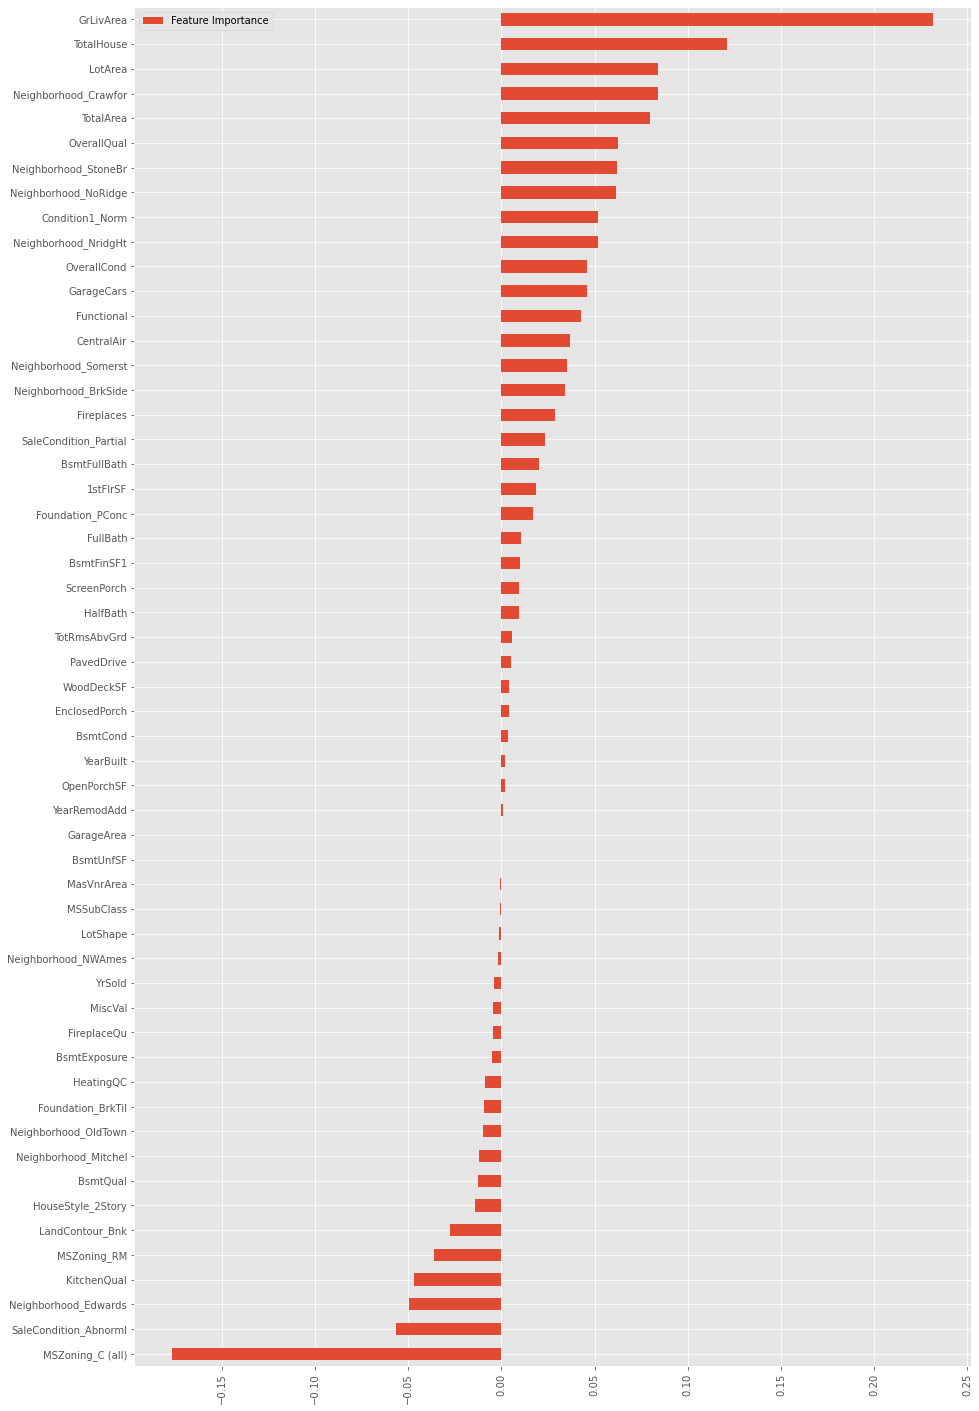

In [153]:

trainFinalFI = pd.DataFrame(trainFinal)
yFinalFI = yFinal

lasso=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(trainFinalFI,yFinalFI)

FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=trainFinalFI.columns)

FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [154]:
trainFinal = pd.DataFrame(trainFinal)

ColsMissingValues = trainFinal.isnull().sum()
print("There are ", len(ColsMissingValues[ColsMissingValues>0]), " features with missing values")
#print("_"*80)
all_data_na = (trainFinal.isnull().sum() / len(trainFinal)) * 100
all_data_na = all_data_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data.head(len(ColsMissingValues[ColsMissingValues>0])))
print("_"*80)
print("trainFinal ", trainFinal.shape)
print("yFinal ", yFinal.shape)

There are  0  features with missing values
Empty DataFrame
Columns: [Missing Ratio]
Index: []
________________________________________________________________________________
trainFinal  (1460, 136)
yFinal  (1460,)


In [155]:
def rmse(y, y_pred):
    """
    Calculates rmse
    """
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_cv(model,X,y):
    """
    Function for cross validation
    """
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [156]:
models = [
    Lasso(alpha =0.0005, random_state=1), 
    GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=5,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
    XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            learning_rate=0.05, max_depth=3, 
                            min_child_weight=1.7817, n_estimators=2200,
                            reg_alpha=0.4640, reg_lambda=0.8571,
                            subsample=0.5213,
                            random_state =7, nthread = -1),
                 
]
names = ["LASSO","GBR","XGBR"]    

In [157]:
xtrain,xval,ytrain,yval = train_test_split(trainFinal,yFinal, test_size=0.2, random_state=42)

In [196]:
# Run the models and compare
model_scores = {}
model_val_scores = {}
start = time.time()
run_times = []
for name, model in zip(names, models):
    run_time = time.time() - start
    run_times.append(round(run_time,3))
    score = rmse_cv(model, xtrain, ytrain)
    model_scores[name] = score.mean()
    print((f'{name}: score - {score.mean()} ,runtime - {run_time}'))
    
print("______________________validation____________________")
    
for val_name, val_model in zip(names, models):
    run_time = time.time() - start
    score_val = rmse_cv(val_model, xval, yval)
    model_val_scores[val_name] = score_val.mean()
    print((f'{val_name}: score - {score_val.mean()},runtime - {run_time}'))

print("train_shape", xtrain.shape,"validation_shape", xval.shape)
print("_"*80)
for key, value in sorted(model_scores.items(), key = itemgetter(1), reverse = False):
    print(key, value)

LASSO: score - 0.12836715523886952 ,runtime - 0.00013113021850585938
GBR: score - 0.12153142802525974 ,runtime - 0.25489211082458496
XGBR: score - 0.12484821876540841 ,runtime - 42.10493803024292
______________________validation____________________
LASSO: score - 0.12496038652917629,runtime - 60.98628807067871
GBR: score - 0.1556033651859682,runtime - 61.099143981933594
XGBR: score - 0.15162840898646804,runtime - 91.08951210975647
train_shape (1168, 136) validation_shape (292, 136)
________________________________________________________________________________
GBR 0.12153142802525974
XGBR 0.12484821876540841
LASSO 0.12836715523886952


### Lasso

In [198]:
lasso_model = Lasso(alpha =0.0005, random_state=1)
lasso_model.fit(xtrain,ytrain)
y_pred = lasso_model.predict(xval)

In [199]:
lasso_rmse = rmse(yval,y_pred)

In [200]:
lasso_rmse

0.1233850786993335

In [32]:
def get_model():
    """
    Define neural network model
    """
    model = Sequential([
        Dense(10, input_shape = xtrain.shape, activation = 'relu'), #10 neurons, Input Layer
        Dense(20, activation = 'relu'),                     #20 neurons, Hidden Layer
        Dense(5, activation = 'relu'),                      #5  neurons, Hidden Layer
        Dense(1)                                            #Output Layer
    ])                                                      #'relu' activation

    model.compile(
        loss='mse',                                         #Trained using Mean square error loss (Cost function) 
        optimizer='adam'                                    #Optimizer used is 'adam' (One of the Fastest optimizers)
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1168, 10)          1370      
_________________________________________________________________
dense_1 (Dense)              (None, 1168, 20)          220       
_________________________________________________________________
dense_2 (Dense)              (None, 1168, 5)           105       
_________________________________________________________________
dense_3 (Dense)              (None, 1168, 1)           6         
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [180]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5) #Defining early stopping parameter

model = get_model()

preds_on_untrained = model.predict(xval) #Make predictions on the val set before training the parameters
start = time.time()
#Finally training the model-->
history = model.fit(
    xtrain, ytrain,
    validation_data = (xval, yval),
    epochs = 100,
    callbacks = [early_stopping]
)
nn_run_time = time.time() - start
print("run_time",nn_run_time)

Epoch 1/100
37/37 [==============================] - 1s 9ms/step - loss: 10381.6875 - val_loss: 109.0383
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 66.6461 - val_loss: 37.5296
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 29.6264 - val_loss: 19.9947
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 16.5823 - val_loss: 14.3866
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 11.5355 - val_loss: 10.8073
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 7.9301 - val_loss: 7.4225
Epoch 7/100
37/37 [==============================] - 0s 3ms/step - loss: 5.3054 - val_loss: 5.3791
Epoch 8/100
37/37 [==============================] - 0s 4ms/step - loss: 3.9550 - val_loss: 4.1108
Epoch 9/100
37/37 [==============================] - 0s 3ms/step - loss: 3.1036 - val_loss: 3.3180
Epoch 10/100
37/37 [==============================] - 0s 3ms/step - loss: 2.5610 - val_loss: 2.

37/37 [==============================] - 0s 4ms/step - loss: 0.1068 - val_loss: 0.1522
Epoch 70/100
37/37 [==============================] - 0s 5ms/step - loss: 0.1150 - val_loss: 0.1640
Epoch 71/100
37/37 [==============================] - 0s 5ms/step - loss: 0.1040 - val_loss: 0.1668
Epoch 72/100
37/37 [==============================] - 0s 3ms/step - loss: 0.0995 - val_loss: 0.1526
Epoch 73/100
37/37 [==============================] - 0s 4ms/step - loss: 0.1064 - val_loss: 0.1522
run_time 11.929606199264526


In [207]:
model.fit(xtrain, ytrain)
ypred = model.predict(xval)

In [208]:
nn_rmse = rmse(yval,ypred)

In [209]:
nn_rmse

0.13004474832537707

### Xtreme Boost (XGB)

In [178]:
XGR_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            learning_rate=0.01, max_depth=5, 
                            min_child_weight=2.0, n_estimators=2000,
                            reg_alpha=0.5, reg_lambda=1.0,
                            subsample=0.5,
                            random_state =7,nthread = 1)
XGR_model.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=2.0, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=1, nthread=1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.5, reg_lambda=1.0, scale_pos_weight=1,
             subsample=0.5, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [203]:
yPred = XGR_model.predict(xval)
xgb_rmse = rmse(yval,yPred)

In [204]:
xgb_rmse

0.12806529000733727

### Gradient boost

In [161]:
GBR_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05,max_depth=5,max_features='sqrt',min_impurity_decrease=0.0,
             min_impurity_split=None,min_samples_leaf=10, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=2500,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
GBR_model.fit(xtrain,ytrain)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='sqrt',
                          min_samples_leaf=10, min_samples_split=10,
                          n_estimators=2500, presort='auto')

In [201]:
yPred = GBR_model.predict(xval)
gbr_rmse = rmse(yval,yPred)

In [202]:
gbr_rmse

0.13620633045706998

In [63]:
testFinal = pd.DataFrame(testFinal)

In [163]:
# SUBMISSION
X_test = testFinal.copy()
sub = pd.read_csv("sample_submission.csv")
pred = np.exp(XGR_model.predict(X_test))
sub.SalePrice=pred
sub.to_csv("submission7.csv",index=False)

In [210]:
model_ = ['Lasso','Gradient Boost','XGBoost','Neural Network']
scores = [lasso_rmse,gbr_rmse,xgb_rmse,nn_rmse]
run_times.append(round(nn_run_time,3))

In [216]:
kaggle_scores = [0.13,0.133,0.124,2.56]

In [218]:
pd.DataFrame({'model':model_,
             'score': scores,
             'runtime':run_times,
             'submission_score':kaggle_scores})

,model,score,runtime,submission_score
0,Lasso,0.123385,0.000,0.130
1,Gradient Boost,0.136206,0.255,0.133
2,XGBoost,0.128065,42.105,0.124
3,Neural Network,0.130045,11.930,2.560


#### Conclusion
After submission and evaluation, the best score on the leaderboard was gotten by XGBoost, which gave a score of **0.124**.

Future improvements
- Feature crossing can be tried to see if the model performs better
- The model can be optimized better to reduce time 
- Iterative process can be done continuosly to improve model
- More features can be generated from base features, such as age of building etc.